# Sparse Kernel Machines

## Abstract

[Link to source code](https://github.com/EpicET/EpicET.github.io/blob/main/posts/blog7/kernel_logistic.py)

In this post, we explore sparse kernel logistic regression using radial basis function (RBF) kernels. We demonstrate how sparsity naturally emerges in these models, meaning only a subset of training points — the support vectors — contribute significantly to the final decision function. We examine how key hyperparameters like the regularization strength (𝜆) and the kernel sharpness (𝛾) influence model behavior, including sparsity, decision boundaries, and overfitting. Through several experiments, we visualize decision surfaces, investigate the impact of parameter choices, and show how kernel methods can capture nonlinear patterns effectively. To evaluate generalization, we conclude with an overfitting case study using ROC curves to compare training and test performance.


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Classification and kernel code adapted from Prof. Phil


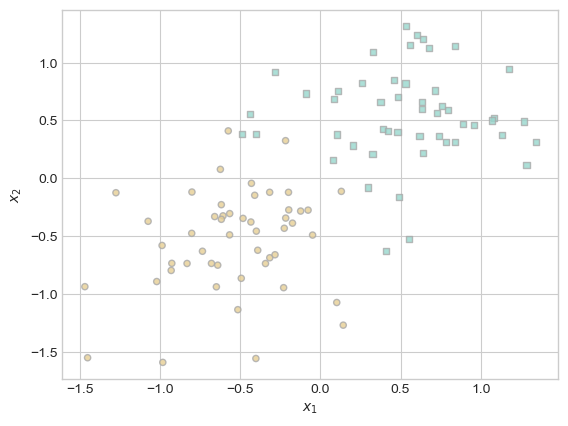

In [15]:
import torch
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")


def classification_data(n_points=300, noise=0.2, p_dims=2):

    y = torch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    X = X - X.mean(dim=0, keepdim=True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o", ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(
            X[ix, 0],
            X[ix, 1],
            s=20,
            c=y[ix],
            facecolors="none",
            edgecolors="darkgrey",
            cmap="BrBG",
            vmin=-1,
            vmax=2,
            alpha=0.8,
            marker=markers[i],
        )
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")


fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points=100, noise=0.4)
plot_classification_data(X, y, ax)

In [16]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma * torch.cdist(X_1, X_2) ** 2)

Defined a rbf kernel machine based on Prof. Phil's code.

In [17]:
from kernel_logistic import KernelLogisticRegression

KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

In [18]:
(1.0 * (KR.a > 0.001)).mean()

tensor(0.5300)

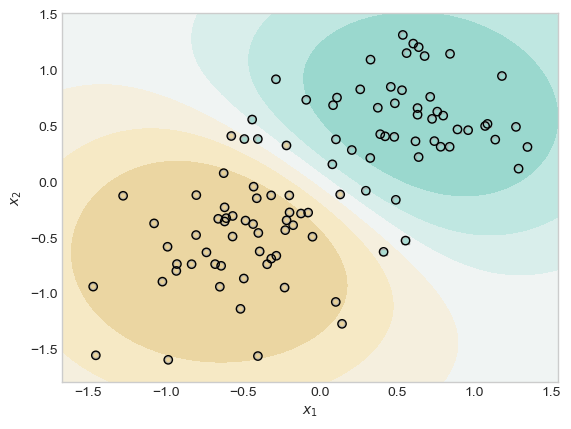

In [19]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing="ij")

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim=1)

preds = KR.prediction(X_, recompute_kernel=True)
preds = 1.0 * torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(
    X1,
    X2,
    preds,
    origin="lower",
    cmap="BrBG",
    vmin=2 * preds.min() - preds.max(),
    vmax=2 * preds.max() - preds.min(),
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0], X[ix, 1], facecolors="none", edgecolors="black")
plt.show()

## Basic Experiments

### Experiment 1: Large lambda

This experiment shows that when 𝜆 is very large, there may be only one point in the training data with a wieght distinguishable from zero.


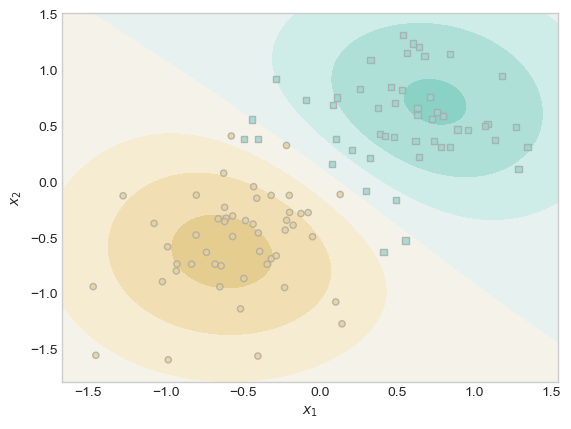

In [20]:
KR = KernelLogisticRegression(rbf_kernel, lam=166, gamma=1)
KR.fit(X, y, m_epochs=20000, lr=0.0001)

ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing="ij")

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim=1)

preds = KR.prediction(X_, recompute_kernel=True)
preds = 1.0 * torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(
    X1,
    X2,
    preds,
    origin="lower",
    cmap="BrBG",
    vmin=2 * preds.min() - preds.max(),
    vmax=2 * preds.max() - preds.min(),
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0], X[ix, 1], facecolors="none", edgecolors="black")
plt.show()

At a lambda of ~166, there was only 1 data point in the center of brown region that had a distinguishable weight.

### Experiment 2: Changing gamma

This experiment is to whow that changing 𝛄 can result in wigglier descision boundaries.


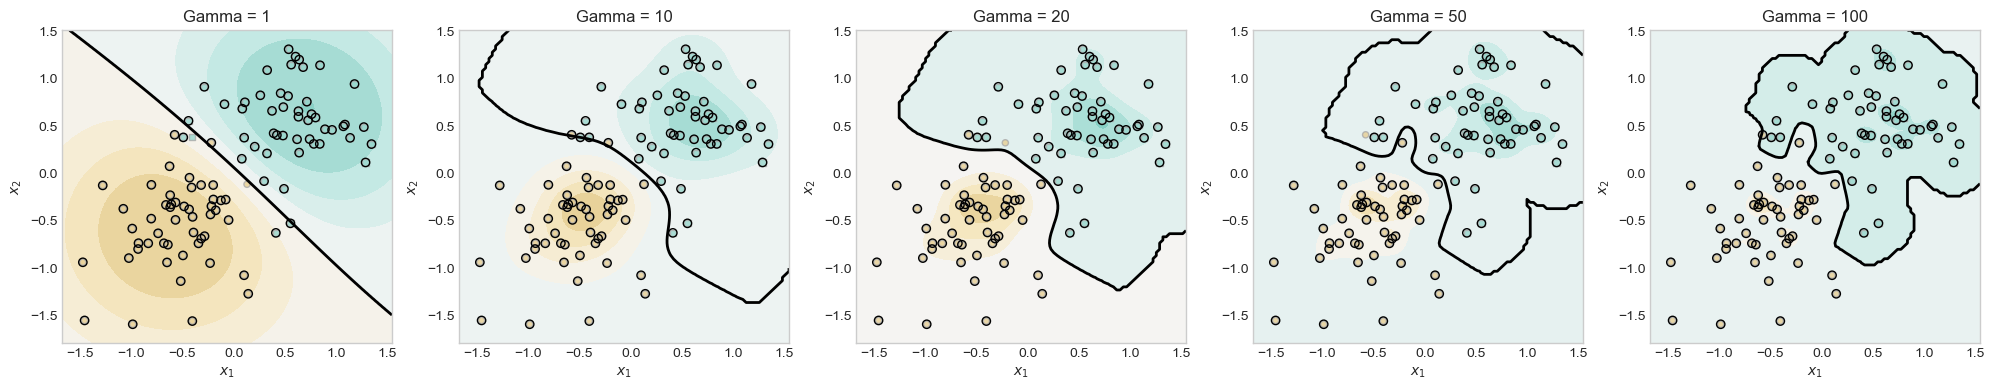

In [21]:
gammas = [1, 10, 20, 50, 100]  # List of gamma values to try
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # One row, 5 subplots

for i, gamma in enumerate(gammas):
    KR = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=gamma)
    KR.fit(X, y, m_epochs=10000, lr=0.0001)

    ix = torch.abs(KR.a) > 0.001

    x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
    x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    x1_r = X1.ravel()
    x2_r = X2.ravel()
    X_ = torch.stack((x1_r, x2_r), dim=1)

    preds = KR.prediction(X_, recompute_kernel=True)
    preds = torch.reshape(preds, X1.size())

    axs[i].set_title(f"Gamma = {gamma}")
    
    axs[i].contourf(
        X1,
        X2,
        preds,
        origin="lower",
        cmap="BrBG",
        vmin=2 * preds.min() - preds.max(),
        vmax=2 * preds.max() - preds.min(),
    )
    # Actual decision boundary at probability 0.5
    axs[i].contour(X1, X2, preds, levels=[0.5], colors='black', linewidths=2)

    plot_classification_data(X, y, axs[i])
    axs[i].scatter(X[ix, 0], X[ix, 1], facecolors="none", edgecolors="black", label='Support Vectors')

plt.tight_layout()
plt.show()


In this experiment, I test my model with a gammas of 1, 10, 20, 50, 100 to see with the decision boundaries looked like. I observed that is the gamma increased the boundaries became more focused on one class and more wiggly.

### Experiment 3: Dealing with nonlinear data

This experiment shows that the kernelized model can still find the pattern within nonlinear data. 
First, I generate nonlinear data for the model to use. 

In [22]:
from sklearn.datasets import make_moons

X_nonlinear, y_nonlinear = make_moons(n_samples=400, noise=0.9)


X_nonlinear = torch.tensor(X_nonlinear, dtype=torch.float32)
y_nonlinear = torch.tensor(y_nonlinear, dtype=torch.float32)

Then I run the usual graphing code to visualize results.

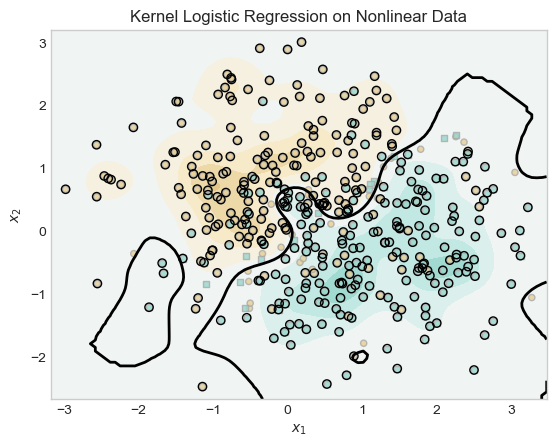

In [26]:
KR = KernelLogisticRegression(rbf_kernel, lam=1.0, gamma=10)
KR.fit(X_nonlinear, y_nonlinear, m_epochs=200000, lr=0.0001)

ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X_nonlinear[:, 0].min() - 0.2, X_nonlinear[:, 0].max() + 0.2, 101)
x2 = torch.linspace(X_nonlinear[:, 1].min() - 0.2, X_nonlinear[:, 1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing="ij")

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim=1)

preds = KR.prediction(X_, recompute_kernel=True)
preds = 1.0 * torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(
    X1,
    X2,
    preds,
    origin="lower",
    cmap="BrBG",
    vmin=2 * preds.min() - preds.max(),
    vmax=2 * preds.max() - preds.min(),
)

ax.contour(X1, X2, preds, levels=[0.5], colors='black', linewidths=2)

plot_classification_data(X_nonlinear, y_nonlinear, ax)
plt.scatter(X_nonlinear[ix, 0], X_nonlinear[ix, 1], facecolors="none", edgecolors="black")
plt.title("Kernel Logistic Regression on Nonlinear Data")
plt.show()

In this experiment, the model is used to classify classify nonlinear data generated by make_moons. Initially, with a low gamma value (γ = 0.01), the model underfit the data, producing a nearly linear decision boundary that failed to capture the curved structure of the classes. By increasing gamma to 10, the kernel returned a more accurate nonlinear decision boundaries. Both separated concentrations of the blue region from the brown.s

## Overfitting

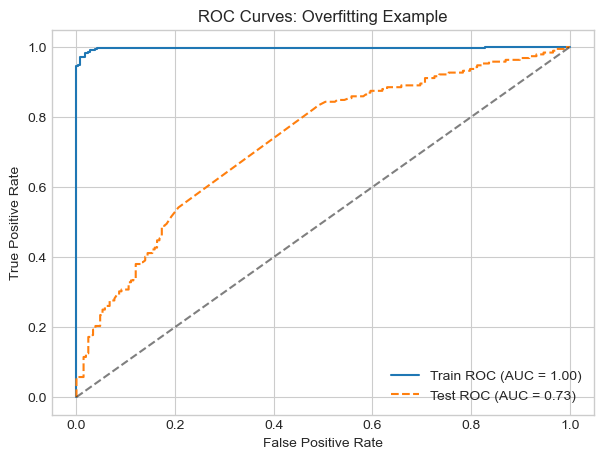

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Generate and split data
X_over, y_over = classification_data(n_points=1000, noise=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.4, random_state=42)

# Fit a model with high gamma (likely to overfit)
KRO = KernelLogisticRegression(rbf_kernel, lam=1e-5, gamma=1000)
KRO.fit(X_train, y_train, m_epochs=30000, lr=0.0001)

# Predict probabilities on train and test
with torch.no_grad():
    y_train_scores = KRO.prediction(X_train, recompute_kernel=True)
    y_test_scores = KRO.prediction(X_test, recompute_kernel=True)

# Convert to NumPy for sklearn
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()
train_scores_np = y_train_scores.numpy()
test_scores_np = y_test_scores.numpy()

# Compute ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_np, train_scores_np)
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_scores_np)

# Compute AUC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {roc_auc_train:.2f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {roc_auc_test:.2f})", linestyle='--')
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Overfitting Example")
plt.legend()
plt.grid(True)
plt.show()

In this experiment, we simulate the problem of overfitting by training a kernel logistic regression model with extremely high gamma of 1000. This allows the model to fit the training data very closely, but it generalizes poorly to unseen test data.

The (AUC) score for training set was near with perfect with 0.99 but the testing set was near 0.72. This large gap between train and test AUCs is a sign that there is overfitting.


## Discussion

In this post, I explored the behavior of sparse kernel logistic regression with RBF kernels through several experiments:

- Sparsity and Regularization: When using a large regularization parameter (𝜆 = 166), only 1 out of 100 training points had a weight (α) greater than 0.001, demonstrating extreme sparsity. In contrast, with a smaller 𝜆 (e.g., 0.1), a larger fraction of points acted as support vectors, contributing to the decision boundary.

- Effect of Gamma (𝛾): By varying 𝛾 from 1 to 100, we observed that the decision boundary became increasingly complex and less smooth. For example, at 𝛾 = 1, the boundary was broad and circular, while at 𝛾 = 100, it became highly irregular, closely fitting the training data.

- Nonlinear Data: On a challenging, noisy dataset (400 points, noise = 0.9), the kernelized model with 𝛾 = 10 was still able to capture the nonlinear patterns.

- Overfitting: Training with a very high 𝛾 (1000) and low 𝜆 (1e-5) on a larger dataset (1000 points, noise = 0.8), the model achieved a near-perfect training AUC of 0.99, but the test AUC dropped to 0.72. This large gap quantitatively demonstrates overfitting: the model fits the training data extremely well but fails to generalize.


I spent a lot of time readjusting and making the kernel logistic regression especially with the grad function. So I would say my debugging skills with dimension/shape related errors. 
